# NOTEBOOK ML 

## In this notebook, you can find all the Machine Learning code for this project. In this case, I built a clustering model to group credit cards into different segments. The goal was to explore whether the model could detect meaningful patterns in the data and identify potential target groups within each cluster.

### Libraries

In [119]:
# Import numerical and data manipulation libraries
import numpy as np # Library for numerical operations (arrays, math functions, etc.)
import pandas as pd # Library for data manipulation and analysis (DataFrames)
# Import visualization libraries
import seaborn as sns # Library for creating statistical visualizations
import matplotlib.pyplot as plt # Library for creating basic plots and charts
# Import preprocessing tools from scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder # StandardScaler: standardizes numerical features (mean=0, std=1), OneHotEncoder: encodes categorical variables into numerical dummy variables
from sklearn.compose import ColumnTransformer # Allows combining different preprocessing steps for numerical and categorical columns in a single pipeline
# Import clustering algorithms
from sklearn.cluster import KMeans # KMeans: partitions data into a predefined number of clusters
from sklearn.cluster import DBSCAN # DBSCAN: density-based clustering, detects arbitrary-shaped clusters and outliers
from sklearn.cluster import AgglomerativeClustering # AgglomerativeClustering: hierarchical clustering method
# Import evaluation metric
from sklearn.metrics import silhouette_score # Measures how well each object lies within its cluster (higher = better separation between clusters)
# Import pipeline utility
from sklearn.pipeline import Pipeline # Chains preprocessing and modeling steps into one streamlined workflow
# Import data imputation tool
from sklearn.impute import SimpleImputer # Replaces missing values with a chosen strategy (mean, median, most frequent, etc.)

In [494]:
# Load the dataset into a pandas DataFrame
# Reads the CSV file located in the current directory and stores it in the variable 'df'
df = pd.read_csv('./Dataset_credit_cards_df_2.csv')
# Check the shape of the DataFrame
df.shape

(234, 12)

In [496]:
# Display the first five rows of the dataset
df.head()

,nombre_tarjeta,Tasa de interés mensual,Ingreso mínimo,Cuota de manejo,Marca,Solicitar,Costo de avance en efectivo,Tipo de tarjeta,Tasa de interes no informada,ingreso minimo no informado,Disponibilidad,Bancos
0,Tarjeta de Crédito Bancolombia Mastercard Joven,2.01,200000.0,15490,mastercard,Online,6900,Internacional,1,1,1,Bancolombia
1,Tarjeta de Crédito Banco de Occidente Masterca...,2.24,500000.0,16300,mastercard,Online,6800,Internacional,1,1,1,Banco de Occidente
2,Tarjeta de Crédito Banco de Occidente Visa Joven,2.24,500000.0,16300,visa,Online,6800,Internacional,1,1,1,Banco de Occidente
3,Tarjeta de Crédito Davivienda Visa Liviana,2.16,1423500.0,20000,visa,Presencial,6400,Internacional,1,1,1,Davivienda
4,Tarjeta de Crédito Davivienda Diners Club Liviana,2.16,1423500.0,20000,diners club,Presencial,6400,Internacional,1,1,1,Davivienda


In [498]:
# Display concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   nombre_tarjeta                234 non-null    object 
 1   Tasa de interés mensual       224 non-null    float64
 2   Ingreso mínimo                115 non-null    float64
 3   Cuota de manejo               234 non-null    int64  
 4   Marca                         234 non-null    object 
 5   Solicitar                     184 non-null    object 
 6   Costo de avance en efectivo   234 non-null    int64  
 7   Tipo de tarjeta               234 non-null    object 
 8   Tasa de interes no informada  234 non-null    int64  
 9   ingreso minimo no informado   234 non-null    int64  
 10  Disponibilidad                234 non-null    int64  
 11  Bancos                        234 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 22.1+ KB


In [500]:
# Check for missing values in each column.
df.isnull().sum()

nombre_tarjeta                    0
Tasa de interés mensual          10
Ingreso mínimo                  119
Cuota de manejo                   0
Marca                             0
Solicitar                        50
Costo de avance en efectivo       0
Tipo de tarjeta                   0
Tasa de interes no informada      0
ingreso minimo no informado       0
Disponibilidad                    0
Bancos                            0
dtype: int64

In [502]:
# PROCESSING DATA

# Select numerical and categorical features from the dataframe.
# This step separates the dataset into numeric and categorical columns,
# which allows applying different preprocessing techniques to each type.
num_features = df.select_dtypes(include=['number']).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Define a transformation pipeline for numerical features.
# - Imputer: fills missing values using the median of each column.
# - Scaler: standardizes the data (mean = 0, std = 1) for better model performance.
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])

# Define a transformation pipeline for categorical features.
# - Imputer: replaces missing values with the constant value 'no_disponible'.
# - OneHotEncoder: encodes categorical variables into binary (dummy) variables.
#   The 'handle_unknown=ignore' argument prevents errors with unseen categories.
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='no_disponible')),
                                 ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine both transformation pipelines (numeric and categorical) into a single preprocessor.
# The ColumnTransformer applies the appropriate pipeline to each group of columns.
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# Apply the preprocessing transformations to the dataset.
# This produces a fully processed version of the data (x) that can be used for clustering.
x = preprocessor.fit_transform(df)

# HYPER PARAMETERS OF EACH CLUSTERING MODEL 

# Define the parameter grid for K-Means.
# - n_clusters: number of clusters to test (from 2 to 5)
# - init: initialization method for cluster centroids 
#   ('k-means++' for smart initialization, or 'random' for random starting points)
param_grid_kmeans = {'n_clusters':[2,3,4,5],
              'init': ['k-means++', 'random']}

# Define the parameter grid for DBSCAN.
# - eps: maximum distance between two samples for them to be considered in the same neighborhood.
# - min_samples: minimum number of points required to form a dense region (a cluster).
param_grid_dbscan = {'eps':[0.5, 1, 1.5, 2, 2.5, 3],
                     'min_samples': [10,15,20,25]}

# Define the parameter grid for Agglomerative Clustering.
# - n_clusters: number of clusters to form in the hierarchical clustering model.
param_grid_agg = {'n_clusters': [2,3,4,5]}

# Create an empty list to store the results of each model and parameter combination.
# Later, each test (model + hyperparameter combination) will append its performance here.
results = [] 

# LOPS TO TRAINING EACH MODEL 

# --- K-MEANS CLUSTERING ---
# Iterate over all combinations of 'n_clusters' and 'init' defined in the parameter grid.
for cluster in param_grid_kmeans['n_clusters']:
    for init in param_grid_kmeans['init']:
        # Create a pipeline that includes preprocessing and the K-Means model.
        model_kmeans = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('kmeans', KMeans(n_clusters=cluster, init=init, random_state=42))
        ])
        # Train the model using the original dataset.
        model_kmeans.fit(df)
        # Extract the cluster labels assigned by the model.
        labels_kmeans = model_kmeans.named_steps['kmeans'].labels_
        #X_transformed_kmeans = model_kmeans.named_steps['preprocessor'].transform(df)
        
        # Calculate the Silhouette Score to evaluate how well the data was clustered.
        score_kmeans = silhouette_score(x, labels_kmeans)
        # Save the results of this configuration (algorithm, parameters, labels, and score).
        results.append({
            'algorithm':'KMeans',
            'params': {'n_clusters':cluster, 'init': init},
            'labels': labels_kmeans,
            'score': score_kmeans
        })


# --- DBSCAN CLUSTERING ---
# Iterate over all combinations of 'eps' and 'min_samples' from the parameter grid.
for eps in param_grid_dbscan['eps']:
    for sample in param_grid_dbscan['min_samples']:
        # Create a pipeline that includes preprocessing and the DBSCAN model.
        model_dbscan = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('dbscan', DBSCAN(eps=eps, min_samples=sample))
        ])
        # Train the model using the original dataset.
        model_dbscan.fit(df)
        # Extract the cluster labels assigned by DBSCAN.
        labels_dbscan = model_dbscan.named_steps['dbscan'].labels_
        # Compute the Silhouette Score only if there is more than one cluster
        # and no noise points (-1). Otherwise, assign a score of -1.
        if len(set(labels_dbscan)) > 1 and -1 not in set(labels_dbscan):
            score_dbscan = silhouette_score(x, labels_dbscan)
        else:
            score_dbscan = -1

        # Save the results of this configuration.
        results.append({
            'algorithm': 'DBSCAN',
            'params': {'eps': eps, 'min_samples':sample},
            'labels': labels_dbscan,
            'score': score_dbscan
        })
        
# --- AGGLOMERATIVE CLUSTERING ---
# Iterate over the possible numbers of clusters.
for cluster in param_grid_agg['n_clusters']:
    # Create a pipeline that includes preprocessing and the Agglomerative model.
    model_agg = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('agg', AgglomerativeClustering(n_clusters=cluster))
    ])

    # Train the model.
    model_agg.fit(df)
    # Extract the cluster labels assigned by the algorithm.
    labels_agg = model_agg.named_steps['agg'].labels_
    # Compute the Silhouette Score for evaluation.
    score_agg = silhouette_score(x, labels_agg)

    # Store the results.
    results.append({
        'algorithm': 'Agglomerative',
        'params': {'n_clusters':cluster},
        'labels': labels_agg,
        'score': score_agg
    })


C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

## Since clustering models can't use Cross-Validation, I decided make some loops for each model with their respective hyperparameters. Of this way I could find the best set possible and begin the training without wasting time with poor sets. the best sets will be to store into a dataframe with all the scores, making it easier to choose which model to train  

In [488]:
# Display the list with all clustering models, their parameters, labels, and silhouette scores.
results

[{'algorithm': 'KMeans',
  'params': {'n_clusters': 2, 'init': 'k-means++'},
  'labels': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'score': 0.2626624918722608},
 {'algorithm': 'KMeans',
  'params': {'n_clusters': 2, 'init': 'random'},
  'l

In [441]:
# Convert the list of clustering results into a pandas DataFrame for easier analysis and visualization.
df_results = pd.DataFrame(results)
# Display the first five rows of the DataFrame to get a quick look at the stored clustering results.
df_results.head()
# Show general information about the DataFrame, including the number of entries, column names, and data types.
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   algorithm  36 non-null     object 
 1   params     36 non-null     object 
 2   labels     36 non-null     object 
 3   score      36 non-null     float64
dtypes: float64(1), object(3)
memory usage: 1.3+ KB


In [443]:
# Filter the results to keep only those models with a silhouette score higher than 0.20 
# and a number of clusters greater than 2 (to avoid overly simple models).
df_best_results = df_results[(df_results['score'] > 0.20) & (df_results['params'].apply(lambda d: d.get('n_clusters', 0) > 2))]
# Sort the filtered results in descending order by silhouette score to identify the best-performing models.
df_best_results = df_best_results.sort_values(by='score', ascending=False)


In [445]:
# Display the filtered and sorted DataFrame containing the best clustering models and their performance scores.
df_best_results

,algorithm,params,labels,score
33,Agglomerative,{'n_clusters': 3},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.342118
35,Agglomerative,{'n_clusters': 5},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.327340
7,KMeans,"{'n_clusters': 5, 'init': 'random'}","[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.324862
5,KMeans,"{'n_clusters': 4, 'init': 'random'}","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.316685
34,Agglomerative,{'n_clusters': 4},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.311585
3,KMeans,"{'n_clusters': 3, 'init': 'random'}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.299934
4,KMeans,"{'n_clusters': 4, 'init': 'k-means++'}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, ...",0.283640
6,KMeans,"{'n_clusters': 5, 'init': 'k-means++'}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, ...",0.283584
2,KMeans,"{'n_clusters': 3, 'init': 'k-means++'}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.219160


### Before beginning the training process. As you could see in the wrangling notebook, I created a new features/flags to help the model identifies better the phatherns. although, there are null values in features like 'Tasa de interes', 'ingreso minimo'. So the model don't work with those null values, in first try, I filled those null values with extreme values like 999 so that the model could indentify values as outliers and separate them but the results aren't consistent enough, even with the additional flags. therefore, I decided filled the missing values with the median instead, however, the results weren't what I expected, those results were better than the previous one.

## First training - 3 clusters 

In [504]:
# Create a K-Means model with 3 clusters
# 'init="random"' means the initial centroids are chosen randomly
# 'random_state=42' ensures reproducibility of the results (same random initialization every time)
k_means = KMeans(n_clusters=3, init='random', random_state=42)

# Create an Agglomerative Clustering model with 3 clusters
# This algorithm doesn't need initial centroids or random initialization
# It builds the clusters hierarchically by progressively merging the most similar observations
agglo = AgglomerativeClustering(n_clusters=3)


In [449]:
y_kmeans

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 2, 4, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       4, 1, 1, 1, 4, 3, 1, 2, 2, 1, 1, 3, 3, 4, 4, 4, 4, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 4, 4, 4, 4, 1, 1, 2, 2, 4,
       4, 4, 1, 1, 3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 2, 2, 2, 2, 4, 3, 3, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2])

In [506]:
# Fit the K-Means model to the data (x) and assign each observation to a cluster
# The resulting cluster labels are stored in a new column called 'clusters_kmeans'
df['clusters_kmeans'] = k_means.fit_predict(x)
# Fit the Agglomerative Clustering model to the same data (x)
# The resulting cluster labels are stored in a new column called 'cluster_agglo'
df['cluster_agglo'] = agglo.fit_predict(x)
# Display the first few rows of the dataframe to verify the new cluster columns
df.head()

C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,nombre_tarjeta,Tasa de interés mensual,Ingreso mínimo,Cuota de manejo,Marca,Solicitar,Costo de avance en efectivo,Tipo de tarjeta,Tasa de interes no informada,ingreso minimo no informado,Disponibilidad,Bancos,clusters_kmeans,cluster_agglo
0,Tarjeta de Crédito Bancolombia Mastercard Joven,2.01,200000.0,15490,mastercard,Online,6900,Internacional,1,1,1,Bancolombia,0,0
1,Tarjeta de Crédito Banco de Occidente Masterca...,2.24,500000.0,16300,mastercard,Online,6800,Internacional,1,1,1,Banco de Occidente,0,0
2,Tarjeta de Crédito Banco de Occidente Visa Joven,2.24,500000.0,16300,visa,Online,6800,Internacional,1,1,1,Banco de Occidente,0,0
3,Tarjeta de Crédito Davivienda Visa Liviana,2.16,1423500.0,20000,visa,Presencial,6400,Internacional,1,1,1,Davivienda,0,0
4,Tarjeta de Crédito Davivienda Diners Club Liviana,2.16,1423500.0,20000,diners club,Presencial,6400,Internacional,1,1,1,Davivienda,0,0


In [453]:
# Define a custom color palette to visually distinguish the clusters in plots.
# Each key corresponds to a cluster label, and each value is a HEX color code.
custom_palette = {
    0: "#1f77b4",  # strong blue
    1: "#ff7f0e",  # orange
    2: "#2ca02c",  # green
    3: "#d62728",  # red
    4: "#9467bd"   # purple
}

<Axes: xlabel='Tasa de interés mensual', ylabel='Ingreso mínimo'>

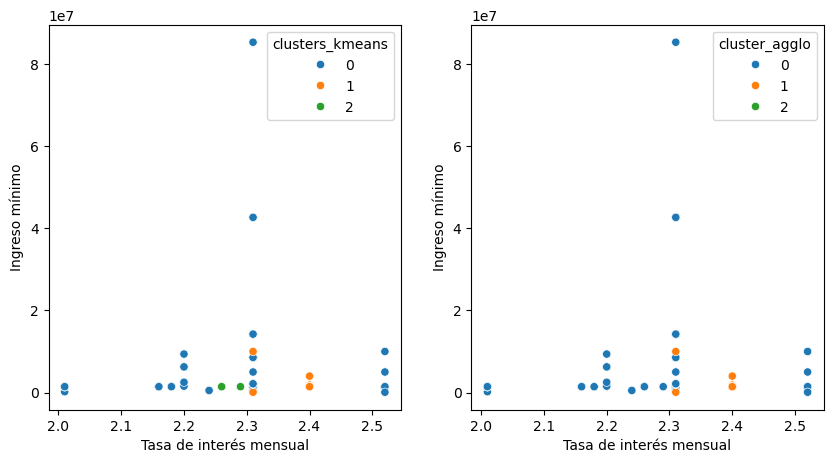

In [532]:
# Create a figure with 1 row and 2 columns of subplots (side by side)
# figsize defines the total size of the figure (10 width x 5 height)
fig, ax = plt.subplots(1,2, figsize=(10,5),squeeze=False)
# Plot a scatterplot showing the K-Means clusters
sns.scatterplot(data=df, x='Tasa de interés mensual', y='Ingreso mínimo', hue='clusters_kmeans', ax=ax[0,0], palette=custom_palette)
# Plot a second scatterplot showing the Agglomerative Clustering results
sns.scatterplot(data=df, x='Tasa de interés mensual', y='Ingreso mínimo', hue='cluster_agglo', ax=ax[0,1], palette=custom_palette)

#### In this plot, we can already identify the three clusters. The separation in the Kmeans model is a little better than the agglomerative model. We can still see a distinction between three groups, however, it's not very clear 

<Axes: xlabel='Cuota de manejo', ylabel='Ingreso mínimo'>

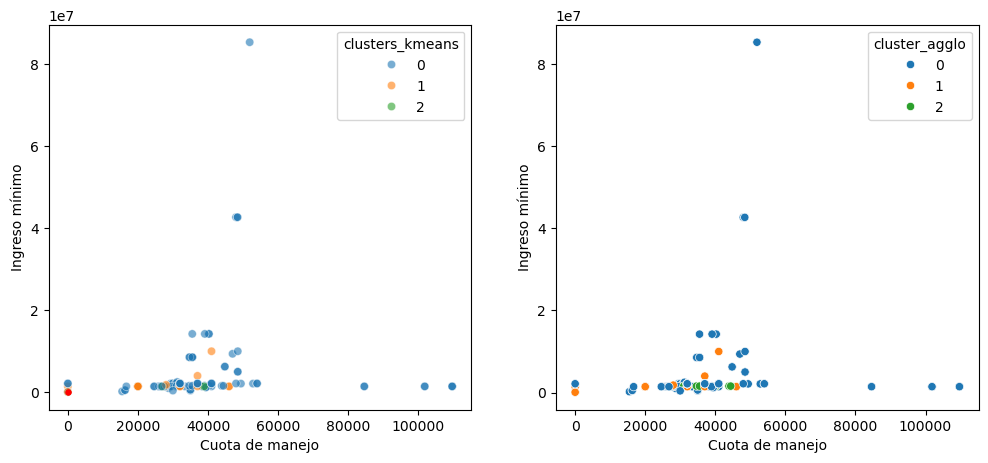

In [534]:
# Create a figure with two subplots side by side (1 row, 2 columns)
# The total figure size is set to 12x5 inches.
fig, ax = plt.subplots(1,2, figsize=(12,5),squeeze=False)

# Plot the K-Means clustering results.
sns.scatterplot(data=df, x='Cuota de manejo', y='Ingreso mínimo', hue='clusters_kmeans', alpha=0.6,ax=ax[0,0], palette=custom_palette)

# Plot the Agglomerative Clustering results on the second subplot.
sns.scatterplot(data=df, x='Cuota de manejo', y='Ingreso mínimo', hue='cluster_agglo', ax=ax[0,1], palette=custom_palette)

#### Unlike the previous plot, in this one we can see that the clusters overlap with each other, making it difficult to identify a clear separation in the data. Based on this observation, we could infer that these features might not be important for the model’s predictions.

<Axes: xlabel='Cuota de manejo', ylabel='Tasa de interés mensual'>

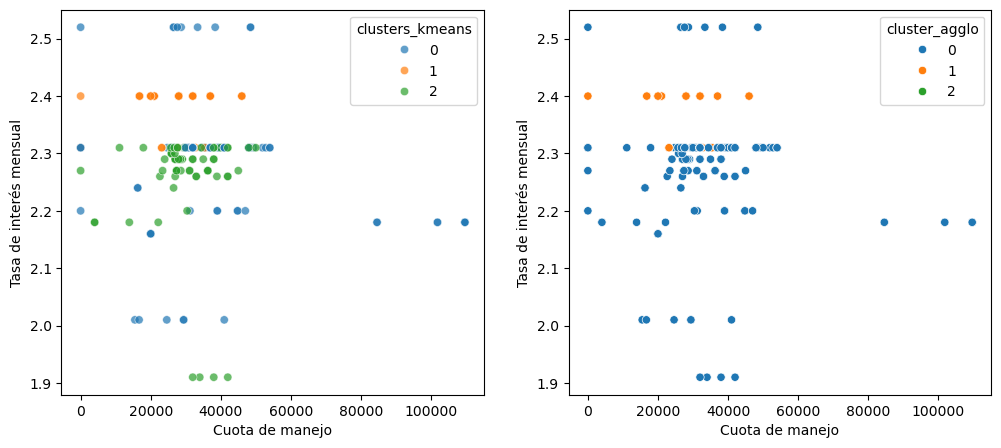

In [536]:
# Create a figure with 1 row and 2 columns of subplots (side by side) and set the figure size to 12x5 inches.
fig, ax = plt.subplots(1,2, figsize=(12,5),squeeze=False)
# Plot a scatterplot showing how 'Cuota de manejo' relates to 'Tasa de interés mensual' for the KMeans clusters.
sns.scatterplot(data=df, x='Cuota de manejo', y='Tasa de interés mensual', hue='clusters_kmeans', alpha=0.7,ax=ax[0,0], palette=custom_palette)
# Plot another scatterplot for the same features, but using the Agglomerative clustering results.
sns.scatterplot(data=df, x='Cuota de manejo', y='Tasa de interés mensual', hue='cluster_agglo', ax=ax[0,1], palette=custom_palette)

#### In these plots, we can draw some conclusions. There is a clear separation between the clusters. It's true that cluster number 0 has several positions in the plot, but this could represent a special type of customer, such as a student or someone with a great economic capacity beyond the normal range. Cluster number 2 seems to represent the standard customer, with products that have lower interest rates, while cluster number 1 directly represents clients with high economic capacity.

#### We must remember that cluster 0 includes some banks offering a variety of products, and perhaps for that reason, it has both high and low values. The target client might depend on the maintenance fee. Also, we can identify that for the model, the feature interest rate is important, as there is a clear separation between clusters — something we already saw in the first plot, but which becomes even clearer here.

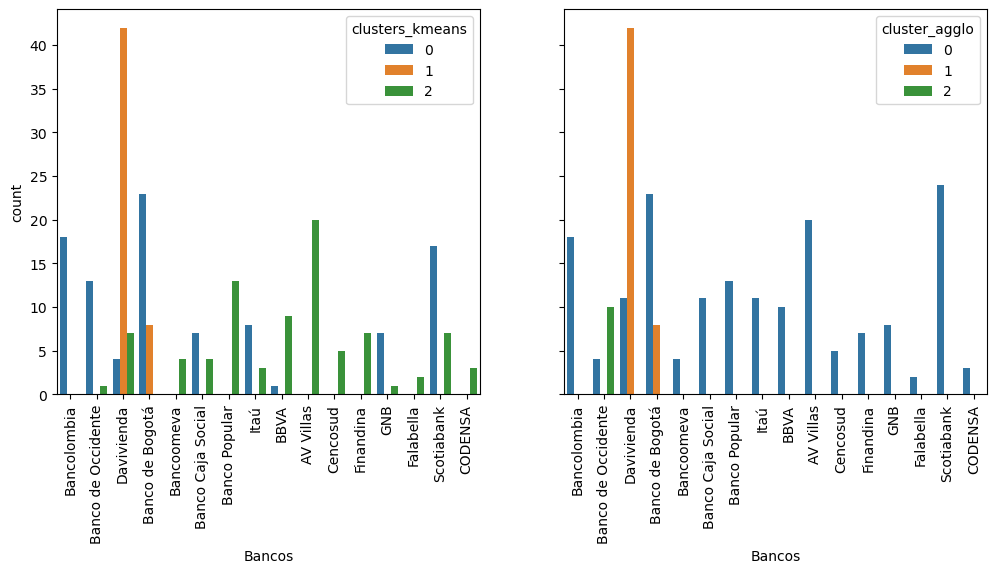

In [538]:
# Create a figure with 1 row and 2 columns, sharing the y-axis to make comparison easier.
fig, ax = plt.subplots(1,2, figsize=(12,5),sharey=True)
#plt.figure(figsize=(10,6))
# Create the first countplot using KMeans clusters.
sns.countplot(data=df,x='Bancos', hue='clusters_kmeans',palette=custom_palette, ax=ax[0])
# Create the second countplot using Agglomerative clusters.
sns.countplot(data=df,x='Bancos', hue='cluster_agglo', palette=custom_palette, ax=ax[1])

# Rotate x-axis labels 90 degrees for both plots to improve readability.
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
# Display both plots side by side.
plt.show()

#### Unlike the previous comparisons between both models, it is quite clear that the Agglomerative model is not performing well, and this plot makes it evident.
#### The KMeans model separates the data better into the usual three groups — low, medium, and high.
#### The Agglomerative Clustering, however, performs worse than KMeans; it seems like there are only two clusters, since cluster number two in the Agglo model is too small.

#### Overall, when looking at the separation by banks, it makes sense: cluster number 1 includes banks offering high-quality products, cluster number 2 contains banks with standard products, and cluster number 0 includes banks that provide a variety of products.

 ### Silhouette Score and Elbow Plot

#### Before moving on to the second and third training rounds, I want to confirm whether the values in df_best_results are actually worth training.
#### To do this, I will also compare them with the Silhouette Score and the Elbow Plot. In this way, I can evaluate and decide the next step more confidently.
#### I don't fully trust the results from df_best_results, since it includes configurations like KMeans with 4 and 5 clusters. However, I must keep in mind that having these results doesn’t necessarily mean they are correct.
#### Therefore, the best option is to compare both plots with the dataframe and decide the next step based on that analysis. 

C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

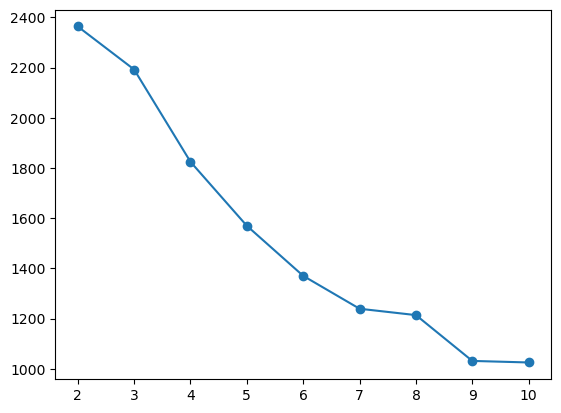

In [540]:
# Define the range of cluster numbers (k) to test, from 2 to 10
k_values = range(2,11
            )
# Create an empty list to store the inertia (within-cluster sum of squares) for each k
inertia_values = []

# Loop through each possible number of clusters
for k in k_values:
    # Initialize a KMeans model with k clusters and a fixed random state for reproducibility
    k_means_for = KMeans(n_clusters=k, random_state=42)
    # Fit the KMeans model to the dataset 'x'
    k_means_for.fit(x)
    # Append the inertia (a measure of how internally coherent the clusters are) to the list
    inertia_values.append(k_means_for.inertia_)
# Plot the inertia values for each k to visualize the "elbow" and help determine the optimal number of clusters
plt.plot(k_values, inertia_values, marker='o')


#### It seems that the results from both the DataFrame and the elbow plot were not good. On one hand, we already know that the DataFrame suggests using 4 or 5 clusters. On the other hand, according to the elbow plot, the model should be trained with 6 or 7 clusters, but that doesn’t make much sense. The best option is still the first one.

C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

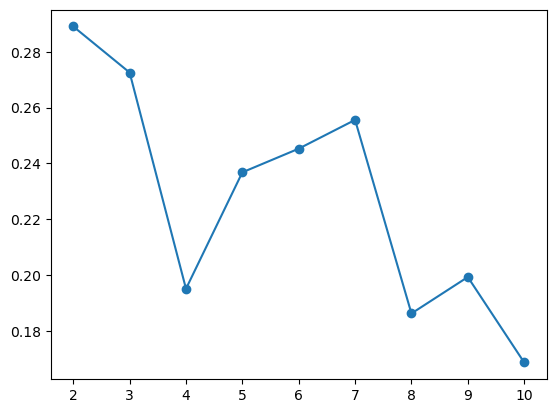

In [542]:
# Create an empty list to store the silhouette scores for each number of cluster
silhouette_scores = []
# Define the range of k values (number of clusters) to test, from 2 to 10
k_values = range(2,11)
# Iterate through each possible number of clusters
for k in k_values:
    # Initialize a KMeans model with k clusters and a fixed random seed for reproducibility
    k_means_sil = KMeans(n_clusters=k, random_state=42)
    # Fit the model and predict the cluster labels for the dataset
    labels = k_means_sil.fit_predict(x)
    # Calculate the silhouette score for the current clustering result
    score = silhouette_score(x, labels)
    # Append the silhouette score to the list
    silhouette_scores.append(score)
# Plot the silhouette scores to visually compare the quality of clustering for each k value
plt.plot(k_values, silhouette_scores, marker='o')
    

#### The silhouette score plot makes more sense — it suggests using 2 or 3 clusters. Based on the previous hyperparameters, the model couldn’t split the clusters properly or simply didn’t recognize all of them, which indicates that there might actually be 3 or 4 clusters.
#### We already know that the best option is the first training; even so, I will train the models two more times with 4 and 6 clusters respectively, as those are the values suggested by both the plots and the dataframe, even though the model probably won’t be able to perform well with them.

# second training 

In [545]:
# Create a new KMeans model with 4 clusters and set the random seed for reproducibility
kmeans_2 = KMeans(n_clusters=4, random_state=42)
# Create a new Agglomerative Clustering model with 4 clusters
agglo_2 = AgglomerativeClustering(n_clusters=4)
# Fit the KMeans model and assign each data point to one of the 4 clusters, saving the results in a new column
df['clusters_kmeans_2'] = kmeans_2.fit_predict(x)
# Fit the Agglomerative model and assign each data point to one of the 4 clusters, saving the results in another column
df['cluster_agglo_2'] = agglo_2.fit_predict(x)
#centers_kmeans = k_means 
df.head()

C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,nombre_tarjeta,Tasa de interés mensual,Ingreso mínimo,Cuota de manejo,Marca,Solicitar,Costo de avance en efectivo,Tipo de tarjeta,Tasa de interes no informada,ingreso minimo no informado,Disponibilidad,Bancos,clusters_kmeans,cluster_agglo,clusters_kmeans_2,cluster_agglo_2,clusters_kmeans_3,cluster_agglo_3
0,Tarjeta de Crédito Bancolombia Mastercard Joven,2.01,200000.0,15490,mastercard,Online,6900,Internacional,1,1,1,Bancolombia,0,0,1,0,1,0
1,Tarjeta de Crédito Banco de Occidente Masterca...,2.24,500000.0,16300,mastercard,Online,6800,Internacional,1,1,1,Banco de Occidente,0,0,1,0,1,0
2,Tarjeta de Crédito Banco de Occidente Visa Joven,2.24,500000.0,16300,visa,Online,6800,Internacional,1,1,1,Banco de Occidente,0,0,1,0,1,0
3,Tarjeta de Crédito Davivienda Visa Liviana,2.16,1423500.0,20000,visa,Presencial,6400,Internacional,1,1,1,Davivienda,0,0,1,0,1,0
4,Tarjeta de Crédito Davivienda Diners Club Liviana,2.16,1423500.0,20000,diners club,Presencial,6400,Internacional,1,1,1,Davivienda,0,0,1,0,1,0


<Axes: xlabel='Tasa de interés mensual', ylabel='Ingreso mínimo'>

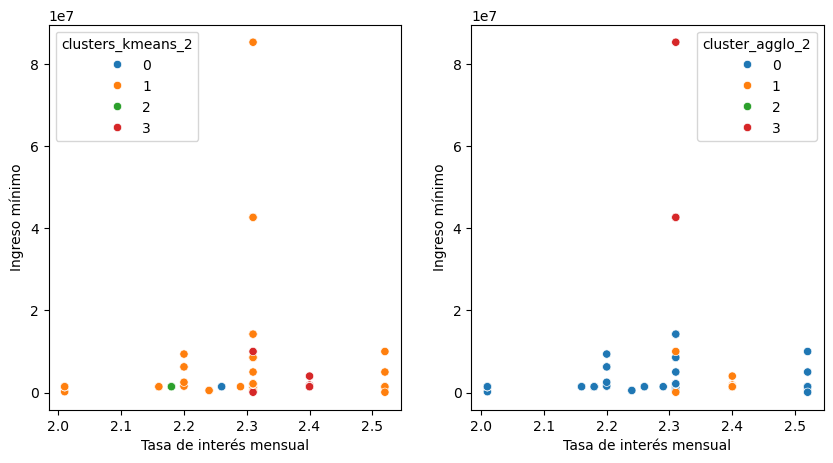

In [547]:
# Create a figure with 1 row and 2 columns of subplots, each one for a different clustering model
fig, ax = plt.subplots(1,2, figsize=(10,5),squeeze=False)
# Plot the KMeans clustering results using 'Tasa de interés mensual' vs 'Ingreso mínimo'
sns.scatterplot(data=df, x='Tasa de interés mensual', y='Ingreso mínimo', hue='clusters_kmeans_2', ax=ax[0,0], palette=custom_palette)
# Plot the Agglomerative clustering results using the same features
sns.scatterplot(data=df, x='Tasa de interés mensual', y='Ingreso mínimo', hue='cluster_agglo_2', ax=ax[0,1], palette=custom_palette)

<Axes: xlabel='Cuota de manejo', ylabel='Ingreso mínimo'>

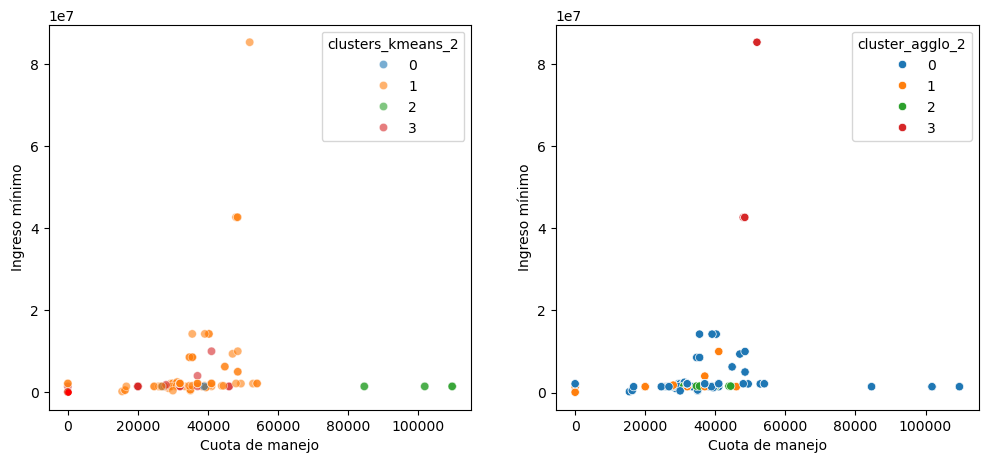

In [548]:
# Create a figure with 1 row and 2 columns of subplots to compare both clustering models
fig, ax = plt.subplots(1,2, figsize=(12,5),squeeze=False)
# Plot the KMeans clustering results using 'Cuota de manejo' vs 'Ingreso mínimo'
sns.scatterplot(data=df, x='Cuota de manejo', y='Ingreso mínimo', hue='clusters_kmeans_2', alpha=0.6,ax=ax[0,0], palette=custom_palette)
# Plot the Agglomerative clustering results using the same features
sns.scatterplot(data=df, x='Cuota de manejo', y='Ingreso mínimo', hue='cluster_agglo_2', ax=ax[0,1], palette=custom_palette)

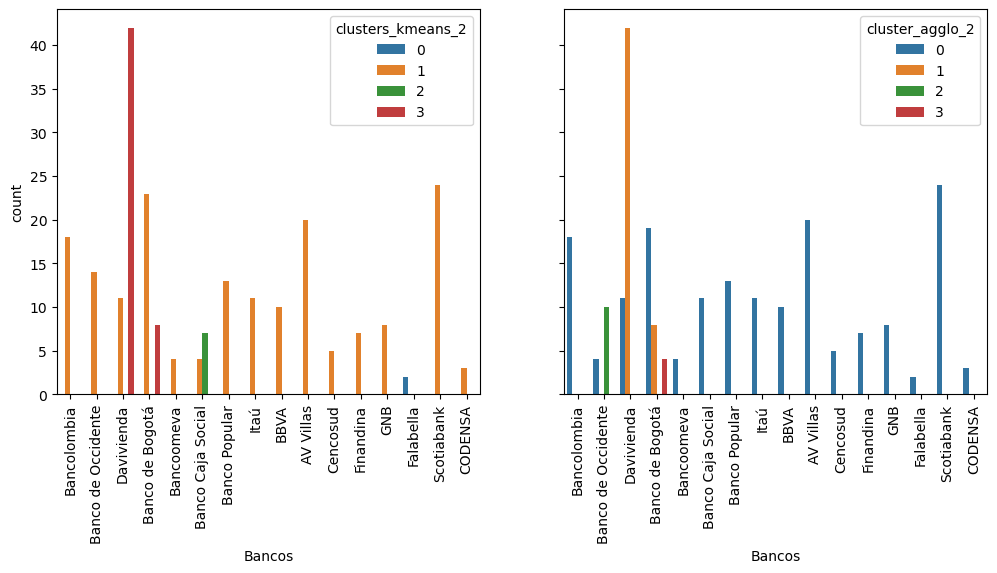

In [551]:
# Create a figure with 1 row and 2 columns of subplots to compare both clustering models
fig, ax = plt.subplots(1,2, figsize=(12,5),sharey=True)
#plt.figure(figsize=(10,6))
# Plot a countplot showing the number of cards per bank for each KMeans cluster (4 clusters)
sns.countplot(data=df,x='Bancos', hue='clusters_kmeans_2',palette=custom_palette, ax=ax[0])
# Plot a countplot showing the same but for the Agglomerative clustering results
sns.countplot(data=df,x='Bancos', hue='cluster_agglo_2', palette=custom_palette, ax=ax[1])
# Rotate the x-axis labels 90 degrees in the first plot to improve readability
ax[0].tick_params(axis='x', rotation=90)
# Rotate the x-axis labels 90 degrees in the second plot for consistency and readability
ax[1].tick_params(axis='x', rotation=90)
plt.show()

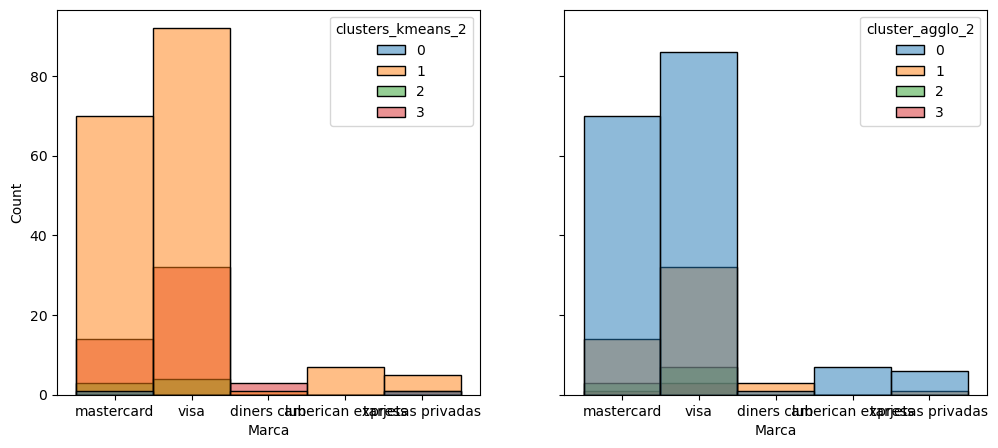

In [553]:
# Create a figure with 1 row and 2 columns of subplots to compare the distributions of clusters from both models
fig, ax = plt.subplots(1,2, figsize=(12,5),sharey=True)
# Plot a histogram showing how the credit card brands ('Marca') are distributed across KMeans clusters
# Each color represents a different cluster
sns.histplot(data=df, x='Marca', hue='clusters_kmeans_2', palette=custom_palette, ax=ax[0])
# Plot a similar histogram but using the Agglomerative clustering labels instead of KMeans
sns.histplot(data=df, x='Marca', hue='cluster_agglo_2', palette=custom_palette, ax=ax[1])
plt.show()

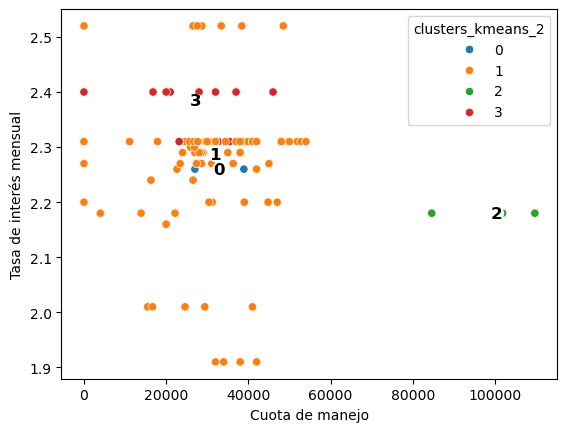

In [555]:
# Define the numerical columns to be used for visualization
x_col = 'Cuota de manejo'
y_col = 'Tasa de interés mensual'

# Get the index positions of these columns in the list of numerical features
ix_x = num_features.index(x_col)
ix_y = num_features.index(y_col)

# Extract the cluster centers from the KMeans model
centers_scaled = kmeans_2.cluster_centers_

# Retrieve the scaler used in the preprocessing pipeline to later revert the scaling
scaler = preprocessor.named_transformers_['num'].named_steps['scaler']

# Extract only the numerical part of the cluster centers
centers_num_scaled = centers_scaled[:,:len(num_features)]

# Inverse transform the scaled centers back to their original scale for interpretability
centers_num_original = scaler.inverse_transform(centers_num_scaled)

# Extract the x and y coordinates (in original scale) of the cluster centers
cx = centers_num_original[:,ix_x]
cy = centers_num_original[:, ix_y]

# Plot the scatterplot showing the data points colored by their KMeans cluster
sns.scatterplot(data=df, x='Cuota de manejo', y='Tasa de interés mensual' , hue='clusters_kmeans_2', palette=custom_palette)

# Overlay the cluster centers as white dots
plt.scatter(cx, cy, c='white', s=100)

# Add labels (cluster numbers) to each cluster center for easier identification
for i, (x,y) in enumerate(zip(cx,cy)):
    plt.text(x,y, str(i), fontsize=12, fontweight='bold', color='black', ha='center', va='center')

#### as we can see it seems the model doesn't recognize very well the clusters, in this case the cluster number 1 is too large and positioned very close to the cluster number 0. The only remarkable point is that the model classifies the cluster number 2 as an outlier

In [ ]:
centers_num_original

# third training - this training isn't neccessary if you want, you can skip it without any problem. It doesn't include comments.

In [516]:
kmeans_3 = KMeans(n_clusters=6, random_state=42)
agglo_3 = AgglomerativeClustering(n_clusters=6)
df['clusters_kmeans_3'] = kmeans_2.fit_predict(x)
df['cluster_agglo_3'] = agglo_2.fit_predict(x)
#centers_kmeans = k_means 
df.head()
df['cluster_agglo_3'].unique()

C:\Users\santi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([0, 1, 2, 3], dtype=int64)

<Axes: xlabel='Tasa de interés mensual', ylabel='Ingreso mínimo'>

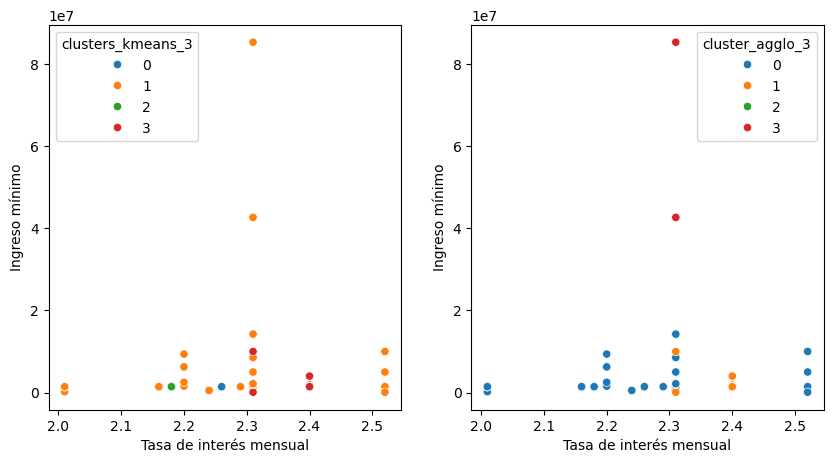

In [528]:
fig, ax = plt.subplots(1,2, figsize=(10,5),squeeze=False)
sns.scatterplot(data=df, x='Tasa de interés mensual', y='Ingreso mínimo', hue='clusters_kmeans_3', ax=ax[0,0], palette=custom_palette)
sns.scatterplot(data=df, x='Tasa de interés mensual', y='Ingreso mínimo', hue='cluster_agglo_3', ax=ax[0,1], palette=custom_palette)

<Axes: xlabel='Cuota de manejo', ylabel='Tasa de interés mensual'>

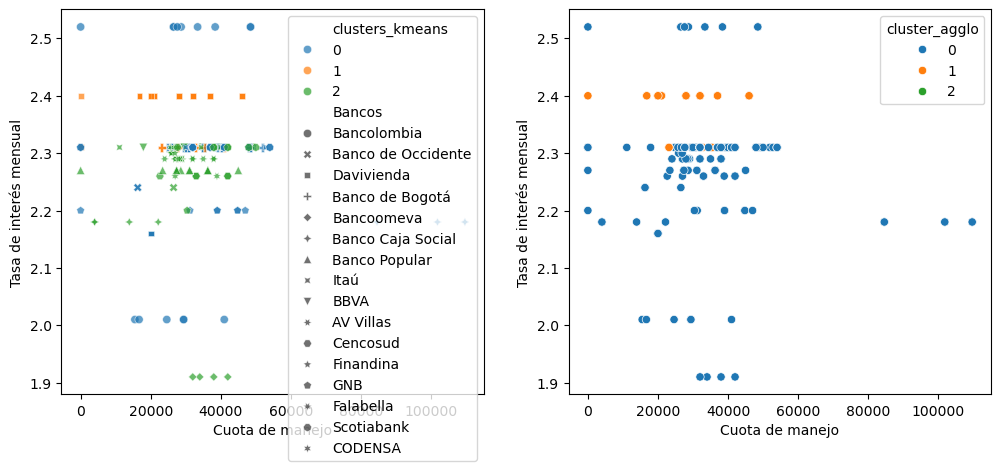

In [561]:
fig, ax = plt.subplots(1,2, figsize=(12,5),squeeze=False)
sns.scatterplot(data=df, x='Cuota de manejo', y='Tasa de interés mensual', hue='clusters_kmeans', style='Bancos',alpha=0.7,ax=ax[0,0], palette=custom_palette)
sns.scatterplot(data=df, x='Cuota de manejo', y='Tasa de interés mensual', hue='cluster_agglo', ax=ax[0,1], palette=custom_palette)

## Metric comparison - first training

In [565]:
# Groups the dataset by the KMeans clusters and calculates the mean values 
# of 'Cuota de manejo' and 'Tasa de interés mensual' for each cluster.
df.groupby('clusters_kmeans')[['Cuota de manejo', 'Tasa de interés mensual']].mean()

,Cuota de manejo,Tasa de interés mensual
clusters_kmeans,,
0,38373.132653,2.286250
1,27218.600000,2.383800
2,29946.023256,2.275233


In [567]:
# Groups the dataset by the KMeans clusters and calculates multiple statistics 
# (mean, median, minimum, and maximum) for both 'Cuota de manejo' and 
# 'Tasa de interés mensual' to get a deeper understanding of each cluster's characteristics.
df.groupby('clusters_kmeans').agg({'Cuota de manejo': ['mean', 'median', 'min', 'max'],
                                  'Tasa de interés mensual': ['mean', 'median', 'min', 'max']})

Cuota de manejo                      Tasa de interés mensual  \
                           mean   median min     max                    mean   
clusters_kmeans                                                                
0                  38373.132653  34962.0   0  109680                2.286250   
1                  27218.600000  28000.0   0   46000                2.383800   
2                  29946.023256  28000.0   0   49990                2.275233   

                                    
                median   min   max  
clusters_kmeans                     
0                 2.31  2.01  2.52  
1                 2.40  2.31  2.40  
2                 2.29  1.91  2.40

### These metrics show how the clusters are divided. Cluster 1 has the highest mean interest rate among the three clusters and the smallest difference between its minimum and maximum values. Its values are high and consistent enough to consider it the cluster representing clients with the highest economic capacity.

### Cluster 0 has the highest individual interest rate (2.52) and the second-highest mean. This is likely the cluster for special clients or exclusive products, as it covers a wide range of values.

### Finally, Cluster 2 represents the typical client — with a medium interest rate and standard products — and has the lowest mean interest rate.

## Note: Some comments and titles were reviewed and improved with the assistance of ChatGPT for clarity and English refinement. All insights, model selection, analysis, and project decisions are my own.
## Nota: Algunos comentarios y títulos fueron revisados y mejorados con la ayuda de ChatGPT para mayor claridad y corrección en inglés. Todos los análisis, interpretaciones, decisiones y conclusiones son completamente propios.